# Fine Tune Test 
Test for fine tuning language models using LoRa on Bath's Hex Cloud

# Setting up on Hex Cloud
## Getting Access
- if you don't have permission to a cluster/machine, email Tom Haines
- open a terminal and sign in via ssh and input your password
    ```
    ssh uniusername@clustername.cs.bath.ac.uk
    ```
    If the following doesn't work, make sure that you're in Bath and if not, connect to the university's VPN or any other VPN
- once you're in you want to navigate to the the fast/er folders. You want to do all of your projects there because they're the least laggy and you have up to 3.8T of storage for your project (varies)
    <img src="assets/s1.png" width = "300">
- the following is an example of how you would access the fast/faster project files
- check which of the files has the most space and create a folder with your username
- do not put any confidential information or API keys within this folder. If you want to use that, put that in your home folder and call them from your project folder

## Getting Access via VsCode
- if you want to 


In [1]:
# change this based on the server usage
# need to run this first to make sure that it runs on the correct GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, TrainingArguments, pipeline, BitsAndBytesConfig
from huggingface_hub import login, snapshot_download, hf_hub_download
from datasets import load_dataset
from trl import SFTTrainer
import torch
import math
from tqdm import tqdm
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
import torch.nn as nn
import pynvml
import matplotlib.pyplot as plt
from accelerate import init_empty_weights, infer_auto_device_map
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import gc

/mnt/faster2/dc903/CS4RP/fttenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"Number of available GPUs: {torch.cuda.device_count()}")

Number of available GPUs: 2


In [4]:
# check VRAM
# if not using Cheery, you will need to change this
def check_vram():
    # Initialize NVIDIA management library
    pynvml.nvmlInit()

    # Get a handle for each GPU device
    handle_list = [pynvml.nvmlDeviceGetHandleByIndex(i) for i in range(pynvml.nvmlDeviceGetCount())]

    info_used = []
    points = [0,1,2,3,4,5,6,7]
    max_vram = 24

    # Iterate over all GPU devices and print VRAM usage
    for handle in handle_list:
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        info_used.append( (info.used//1024**2)/1000)

    print (info_used)

    plt.figure(figsize=(5, 2))
    plt.ylim(0,max_vram)
    plt.bar(points, info_used)
    plt.plot()
    pynvml.nvmlShutdown()

In [ ]:
"""
DO NOT RUN THIS CODE BLOCK IF 'llama-2-7b-hf' IS IN YOUR DIRECTORY
"""

# getting the authorisation from huggingface to use the model (in this case llama 2 7b )
access_key = open('hf_ak.txt','r').read()
login(token = access_key)

# Download model files. If it's in the project directory, there's no need to run this again
# use df -H in the terminal to check and see if there's enough space to download the model
# this process will take a long time
# will save the model in the directory specified
model_path = snapshot_download("meta-llama/Llama-2-7b-hf", local_dir="./llama-2-7b")

- do not run any of this is if llama-2-7b-hf is filled
- You'll need to convert them to the huggingface Transformers format using the conversion script `convert_llama_weights_to_hf.py`. 
- Obviously, hf stands for huggingface. Maybe with the hf version, the conversion wouldn't be needed
- to run this, run the following

```
python convert_llama_weights_to_hf.py \
    --input_dir /llama-2-7b --model_size 7B --output_dir /llama-2-7b-hf

```

[1.079, 5.791, 0.415, 4.677, 0.415, 0.415, 0.418, 0.418]


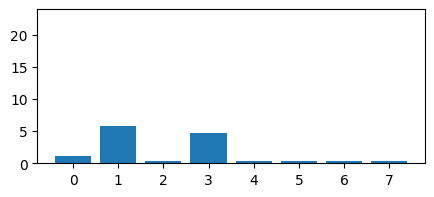

In [5]:
check_vram()

In [6]:
# each GPU util
!nvidia-smi --query-gpu=utilization.gpu --format=csv

utilization.gpu [%]
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %


In [7]:
# Model and tokenizer names
base_model_name = "llama-2-7b-hf"
new_model_name = "llama-2-7b-enhanced" #You can give your own name for fine tuned model

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"

In [8]:
# Model
# resolve device_map_auto issue
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto"
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


[1.079, 5.791, 0.415, 4.677, 0.415, 0.415, 13.479, 13.479]


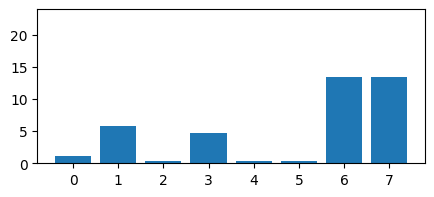

In [9]:
check_vram()

In [14]:
# use the following code if you want to unload the VRAM. You may have to run this more than once to unload
# Remove model from GPU. Add any more variables that can get loaded on

# uncomment this if not deleted
# del base_model
# del llama_tokenizer

# Clear any remaining CUDA memory
torch.cuda.empty_cache()
gc.collect()

3919

0
0
[1.079, 5.791, 0.415, 4.677, 0.415, 0.415, 0.625, 0.625]


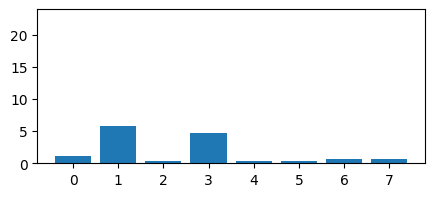

In [15]:
# check if your project is still loaded onto the VRAM
print(torch.cuda.memory_allocated())
# this should return 0 if everything is unloaded
print(torch.cuda.memory_reserved())
check_vram()

In [ ]:
# Data set
# only 1K datapoints but each points has a lot of data
data_name = "mlabonne/guanaco-llama2-1k"
training_data = load_dataset(data_name, split="train")
# check the data
print(training_data.shape)
# #11 is a QA sample in English
print(training_data[11])

In [9]:
# Training Params
train_params = TrainingArguments(
    output_dir="./results_modified",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=50,
    logging_steps=50,
    learning_rate=4e-5,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [ ]:
from peft import get_peft_model
# LoRA Config
# reduce rank r if you're running out of vram
peft_parameters = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, peft_parameters)
model.print_trainable_parameters()

In [ ]:
# Trainer with LoRA configuration
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=training_data,
    peft_config=peft_parameters,
    dataset_text_field="text",
    tokenizer=llama_tokenizer,
    args=train_params
)

# Training
fine_tuning.train()

In [12]:
# Save Model
fine_tuning.model.save_pretrained(new_model_name)

In [ ]:
check_vram()

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto"
)
from peft import LoraConfig, PeftModel
model = PeftModel.from_pretrained(base_model, new_model_name)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"